In [5]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.regressionplots import influence_plot
from IPython.display import display
from tqdm import trange

### Canton-Panel DiD

$\text{crime\_rate}_{cgt}
= \beta\,(T_{g}\times P_{t})
\;+\;FE_{c}
\;+\;FE_{t}
\;+\;FE_{g}
\;+\;\varepsilon_{cgt}.$

In [6]:
# DiD 
df_ct = pd.read_excel("/Users/souhil/Desktop/Courses/Recherche Empirique/Final/Data/processed/crimes_subject_to_law_cleaned_by_canton.xlsx")

good = []
for c in df_ct['canton'].unique():
    sub = df_ct[df_ct['canton']==c]
    good.append(c)
df_ct = df_ct[df_ct['canton'].isin(good)].copy()


# prepare DiD variables
df_ct = df_ct[df_ct['crime_rate_per_100k']>=0]
df_ct['T'] = (df_ct['group']=="Foreigner").astype(int)
df_ct['P'] = (df_ct['year']>=2017).astype(int)
df_ct['T_P'] = df_ct['T'] * df_ct['P']
df_ct['t'] = df_ct['year'] - df_ct['year'].min()
df_ct['T_t'] = df_ct['T'] * df_ct['t']

# 3a) Simple canton panel DiD
mod1 = smf.ols("crime_rate_per_100k ~ T_P + C(canton) + C(year) + C(group)", data=df_ct).fit(cov_type='cluster', cov_kwds={'groups': df_ct['canton']})

print("\nCanton-panel DiD (simple)")
print(mod1.summary())


Canton-panel DiD (simple)
                             OLS Regression Results                            
Dep. Variable:     crime_rate_per_100k   R-squared:                       0.720
Model:                             OLS   Adj. R-squared:                  0.703
Method:                  Least Squares   F-statistic:                     18.12
Date:                 Fri, 06 Jun 2025   Prob (F-statistic):           2.81e-09
Time:                         00:12:05   Log-Likelihood:                -3486.7
No. Observations:                  672   AIC:                             7051.
Df Residuals:                      633   BIC:                             7227.
Df Model:                           38                                         
Covariance Type:               cluster                                         
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 38, but rank is 15
  warnings.warn('covariance of constraints does not have full '


### Canton-Panel DiD (parallelity hypothesis relaxed)

same model with $\theta$ variable to treat for parallelity

$\text{crime\_rate}_{cgt}
= \beta\,(T_{g}\times P_{t})
\;+\;\theta\,(T_{g}\times t)
\;+\;FE_{c}
\;+\;FE_{t}
\;+\;FE_{g}
\;+\;\varepsilon_{cgt},$

In [7]:
mod2 = smf.ols("crime_rate_per_100k ~ T_P + T_t + C(group) + C(canton) + C(year)", data=df_ct).fit(cov_type='cluster', cov_kwds={'groups': df_ct['canton']})

print("\nCanton-panel DiD (with trend)")
print(mod2.summary())


Canton-panel DiD (with trend)
                             OLS Regression Results                            
Dep. Variable:     crime_rate_per_100k   R-squared:                       0.720
Model:                             OLS   Adj. R-squared:                  0.703
Method:                  Least Squares   F-statistic:                     17.40
Date:                 Fri, 06 Jun 2025   Prob (F-statistic):           3.41e-09
Time:                         00:12:05   Log-Likelihood:                -3486.6
No. Observations:                  672   AIC:                             7053.
Df Residuals:                      632   BIC:                             7234.
Df Model:                           39                                         
Covariance Type:               cluster                                         
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 39, but rank is 16
  warnings.warn('covariance of constraints does not have full '


### Canton-Specific DiD Regression Explanation

We estimate the following model:

$
\text{crime\_rate}_{cgt}
= FE_{g}
\;+\;FE_{t}
\;+\;FE_{c}
\;+\;\sum_{c}\beta_{c}\,\Bigl(\mathbf{1}\{\text{canton}=c\}\times T_{g} \times P_{t}\Bigr)
\;+\;\varepsilon_{cgt},$

In [8]:
mod3 = smf.ols("crime_rate_per_100k ~ C(group) + C(year) + C(canton) + C(canton):T_P", data=df_ct).fit()

print(mod3.summary())

                             OLS Regression Results                            
Dep. Variable:     crime_rate_per_100k   R-squared:                       0.774
Model:                             OLS   Adj. R-squared:                  0.752
Method:                  Least Squares   F-statistic:                     34.29
Date:                 Fri, 06 Jun 2025   Prob (F-statistic):          6.95e-159
Time:                         00:12:06   Log-Likelihood:                -3414.1
No. Observations:                  672   AIC:                             6952.
Df Residuals:                      610   BIC:                             7232.
Df Model:                           61                                         
Covariance Type:             nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

## Event study (final test)

$$
\text{crime\_rate}_{cgt}
= FE_{c} + FE_{t} + FE_{g}
+ \sum_{\substack{k=-5 \\ k\neq -1}}^{5}
    \beta_{k}\,\bigl[\mathbf{1}(t-2017 = k)\times D_{g}\bigr]
+ \varepsilon_{igt}
$$

In [9]:
df_ct = df_ct.copy()

# 1) Ensure year is int
df_ct['year'] = df_ct['year'].astype(int)

df_ct['treat'] = (df_ct['group'] == "Foreigner").astype(int)
print("Treated obs:", df_ct['treat'].sum(), "/", len(df_ct))

lead_cols = []
for k in range(-7, 7):
    if k == -1: 
        continue
    suffix = f"m{abs(k)}" if k < 0 else f"p{k}"
    name   = f"lead_{suffix}"
    df_ct[name] = ((df_ct['year'] - 2017) == k).astype(int) * df_ct['treat']
    print(f"{name}: {df_ct[name].sum()} treated obs")
    lead_cols.append(name)

# Event-study regression
formula = "crime_rate_per_100k ~ " + " + ".join(lead_cols) + " + C(canton)+ C(group) + C(year)"
mod_es = smf.ols(formula, data=df_ct).fit(
    cov_type="cluster", cov_kwds={"groups": df_ct["canton"]})
print(mod_es.summary())

Treated obs: 336 / 672
lead_m7: 24 treated obs
lead_m6: 24 treated obs
lead_m5: 24 treated obs
lead_m4: 24 treated obs
lead_m3: 24 treated obs
lead_m2: 24 treated obs
lead_p0: 24 treated obs
lead_p1: 24 treated obs
lead_p2: 24 treated obs
lead_p3: 24 treated obs
lead_p4: 24 treated obs
lead_p5: 24 treated obs
lead_p6: 24 treated obs
                             OLS Regression Results                            
Dep. Variable:     crime_rate_per_100k   R-squared:                       0.730
Model:                             OLS   Adj. R-squared:                  0.708
Method:                  Least Squares   F-statistic:                     21.29
Date:                 Fri, 06 Jun 2025   Prob (F-statistic):           1.40e-10
Time:                         00:12:06   Log-Likelihood:                -3474.5
No. Observations:                  672   AIC:                             7051.
Df Residuals:                      621   BIC:                             7281.
Df Model:                

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 50, but rank is 23
  warnings.warn('covariance of constraints does not have full '


## Counterfactual graph of the DiD

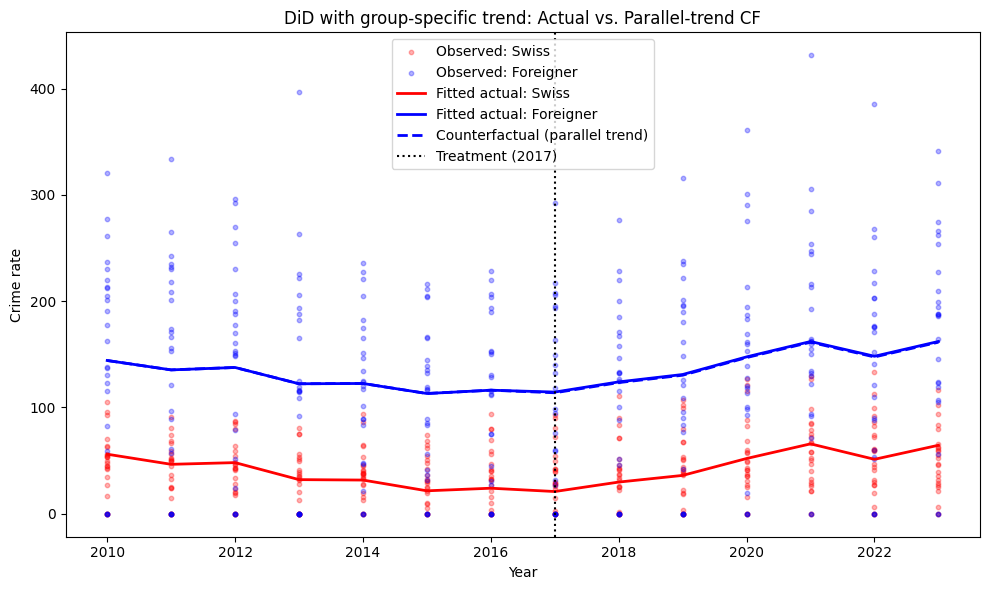

In [10]:
# Build a “counterfactual” dataset where Foreigner keeps its pre-treatment trend:
df_ct_cf = df_ct.copy()
# zero out the post dummy so the Foreigner×Post jump vanishes
df_ct_cf['T_P'] = 0

# keep the group‐specific trend term intact (so slope continues)
# T_t is just time × Foreigner, so it stays

# Predict both actual and counterfactual paths
df_ct['f_actual'] = mod2.predict(df_ct)
df_ct_cf['f_cf']    = mod2.predict(df_ct_cf)

# Aggregate to year × group means
agg = (
    df_ct
    .assign(f_cf=df_ct_cf['f_cf'])
    .groupby(['group','year'])
    .agg(obs_rate=('crime_rate_per_100k','mean'),
         fit_actual=('f_actual','mean'),
         fit_cf    =('f_cf','mean'))
    .reset_index())

plt.figure(figsize=(10,6))

for grp, color in [('Swiss','red'), ('Foreigner','blue')]:
    sub = df_ct[df_ct['group'] == grp]
    plt.scatter(sub['year'], sub['crime_rate_per_100k'],
                color=color, alpha=0.3, s=10,
                label=f'Observed: {grp}')

for grp, color in [('Swiss','red'), ('Foreigner','blue')]:
    sub = agg[agg['group']==grp]
    plt.plot(sub['year'], sub['fit_actual'], color=color, lw=2,
             label=f'Fitted actual: {grp}')
    if grp=='Foreigner':
        plt.plot(sub['year'], sub['fit_cf'], color=color, lw=2, ls='--',
                 label='Counterfactual (parallel trend)')

plt.axvline(2017, color='black', ls=':', lw=1.5, label='Treatment (2017)')

plt.xlabel('Year')
plt.ylabel('Crime rate')
plt.title('DiD with group‐specific trend: Actual vs. Parallel‐trend CF')
plt.legend()
plt.tight_layout()
plt.savefig("/Users/souhil/Desktop/Courses/Recherche Empirique/Final/did_graph_linlin.png", dpi=300, bbox_inches='tight')  
plt.show()